<a href="https://colab.research.google.com/github/Didier06/IA_FABLAB/blob/main/Introduction_IA/Yolov8_Minst_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ======================================================
# 🧠 MNIST multi-chiffres avec YOLOv8m (Ultralytics)
# ======================================================

!pip install ultralytics torchvision tqdm pyyaml --quiet

from torchvision import datasets
from PIL import Image
import random, os, yaml
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.2 MB/s eta 0:00:00


In [6]:
# ======================================================
# 1️⃣ Monter Google Drive pour sauvegarder le modèle
# ======================================================

from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/MNIST_YOLOv8m"
os.makedirs(save_dir, exist_ok=True)
print(f"📁 Modèle sera sauvegardé dans : {save_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Modèle sera sauvegardé dans : /content/drive/MyDrive/MNIST_YOLOv8m


In [7]:
# ======================================================
# 6️⃣ Test de prédiction (sur ton modèle sauvegardé sur Drive)
# ======================================================
from ultralytics import YOLO

# Chemin vers le modèle entraîné (best.pt sur ton Drive)
model_path = "/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/best.pt"

# Charger le modèle final
model = YOLO(model_path)

# Image de test
test_image = "mnist_yolo/images/val/10.jpg"

# Lancer la prédiction et sauvegarder le résultat
results = model.predict(source=test_image, save=True, imgsz=320)

# Afficher la prédiction directement dans Colab
results[0].show()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



FileNotFoundError: mnist_yolo/images/val/10.jpg does not exist


image 1/1 /content/mnist_yolo/images/val/10.jpg: 320x320 2 0s, 2 1s, 1 4, 1 5, 1 6, 2 7s, 1 8, 15.6ms
Speed: 0.8ms preprocess, 15.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
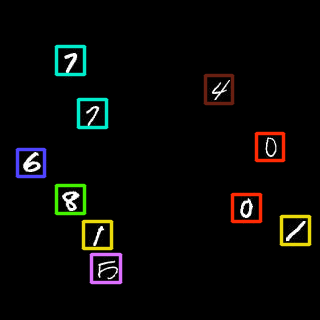

In [ ]:
from ultralytics import YOLO

# Charger ton modèle
model = YOLO("/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/best.pt")

# Faire la prédiction (sans sauvegarde automatique)
results = model.predict(source="mnist_yolo/images/val/10.jpg", save=False, imgsz=320)

# Afficher sans les probabilités
results[0].plot(conf=False, labels=False, save=True)



image 1/1 /content/mnist_yolo/images/val/10.jpg: 320x320 2 0s, 2 1s, 1 4, 1 5, 1 6, 2 7s, 1 8, 15.6ms
Speed: 0.6ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)


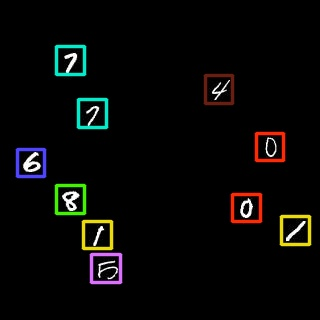

🖼️ Image sauvegardée : /content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/predictions/val10_clean.jpg
📊 Détections : 4:1, 6:1, 8:1, 7:2, 5:1, 1:2, 0:2


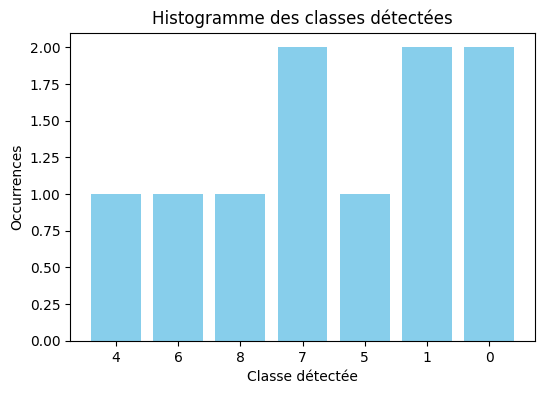

In [ ]:
# ======================================================
# Test YOLOv8 — affichage sans probas + comptage visuel des classes
# ======================================================
from ultralytics import YOLO
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os

# 1️⃣ Charger le modèle
model = YOLO("/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/best.pt")

# 2️⃣ Lancer la prédiction sans sauvegarde automatique
results = model.predict(source="mnist_yolo/images/val/10.jpg", save=False, imgsz=320)

# 3️⃣ Générer et sauvegarder l’image propre (sans probas ni labels)
output_dir = "/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/predictions"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "val10_clean.jpg")

# La fonction plot() retourne l’image → on la sauvegarde proprement
img_clean = results[0].plot(conf=False, labels=False)
import cv2
cv2.imwrite(output_path, cv2.cvtColor(img_clean, cv2.COLOR_RGB2BGR))

# 4️⃣ Afficher l’image dans Colab
display(Image(filename=output_path))
print(f"🖼️ Image sauvegardée : {output_path}")

# ======================================================
# 5️⃣ Comptage des classes détectées
# ======================================================
classes = results[0].boxes.cls.cpu().numpy().astype(int)
counts = Counter(classes)

if counts:
    # Affichage textuel
    summary = ", ".join([f"{cls}:{count}" for cls, count in counts.items()])
    print(f"📊 Détections : {summary}")

    # Tableau de comptage
    df = pd.DataFrame(list(counts.items()), columns=["Classe", "Occurrences"])
    #display(df)

    # 6️⃣ Histogramme (barres)
    plt.figure(figsize=(6,4))
    plt.bar(df["Classe"].astype(str), df["Occurrences"], color="skyblue")
    plt.xlabel("Classe détectée")
    plt.ylabel("Occurrences")
    plt.title("Histogramme des classes détectées")
    plt.show()

else:
    print("❌ Aucune détection trouvée sur cette image.")
